In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

In [8]:
for f in filters:
    print(vars(f))

{}


Search is started.
0- time: 0.25, count_rollouts: 1, reward: -0.43152245620912894, node: PEPTIDE1{[ac].F.Q.P.K.G.N.V.F.Y.F.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
1- time: 0.53, count_rollouts: 2, reward: -0.7730096010518402, node: PEPTIDE1{A.E.L.A.A.L.E.A.E.L.A.A.L.E.G.C.L.G.G.R.W.G.W.D.G.K.L.A.A.L.K.A.K.L.A.A.L.K.A}$$$$
2- time: 0.85, count_rollouts: 4, reward: -0.336493490307569, node: PEPTIDE1{R.[dP].K.[dP].Q.Q.[dF].[dF].G.[dL].M.[am]}$$$$
3- time: 0.91, count_rollouts: 5, reward: -0.46053492978686683, node: PEPTIDE1{Y.V.P.T.N.V.G.S.E.A.F}$$$$
4- time: 0.98, count_rollouts: 6, reward: -0.8749774745392818, node: PEPTIDE1{G.G.R.C.S.Q.Y.R.K.R.K.G.K.E.Y.N.Q.K.I}$$$$
5- time: 1.07, count_rollouts: 7, reward: -0.8281208112338793, node: PEPTIDE1{F.L.G.A.T.G.A.R.K.S.A.R.K.L.A.N.Q.L.G.[am]}$$$$
6- time: 1.17, count_rollouts: 8, reward: 0.016788422454605923, node: PEPTIDE1{A.I.P.W.F.I.I.T.E.K.[am]}$$$$
7- time: 1.23, count_rollouts: 9, reward: -0.7114396632431447, node: PEPTIDE1{T.N.I.K.T.E.E.I.S.E.V.

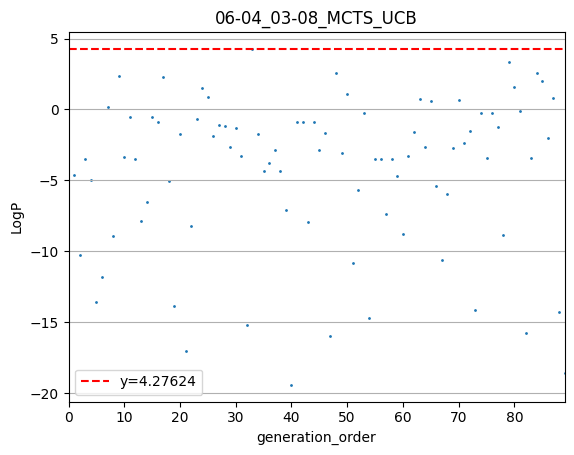

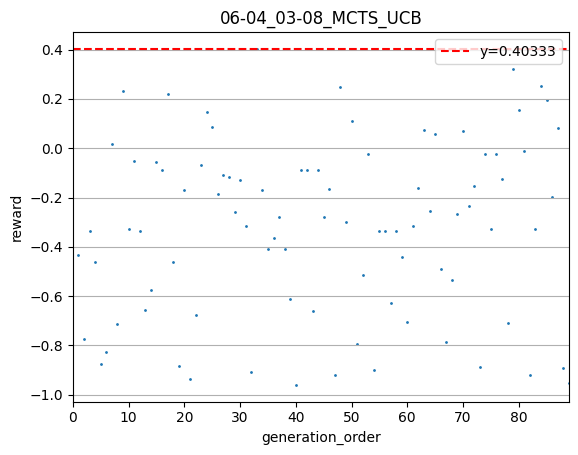

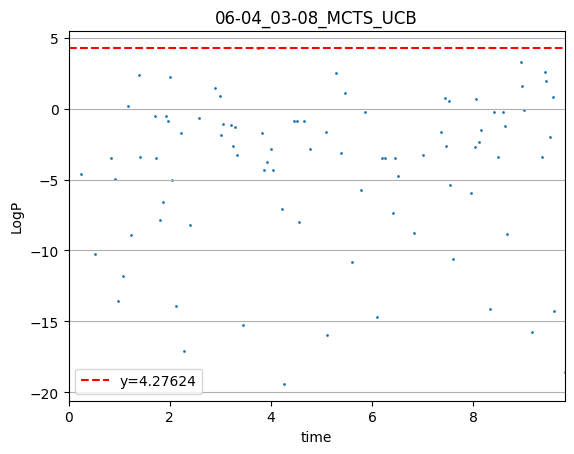

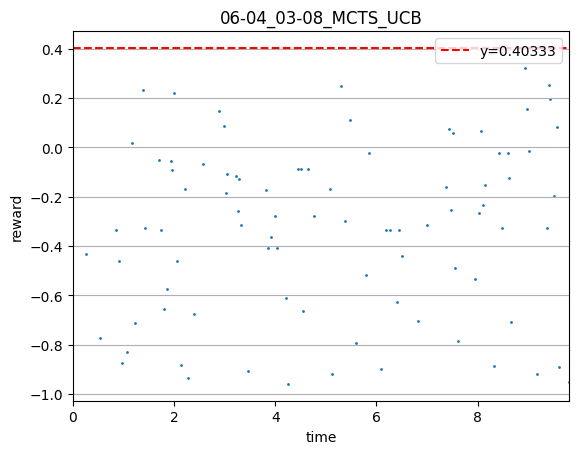

Search is completed.


In [5]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)